In [151]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [150]:
class BipartiteGraph():
    def __init__(self, adj_mat, supply_vec, res):
        self.adj_mat = adj_mat
        self.supply_vec = supply_vec
        self.res = res
        self.m = adj_mat.shape[0]
        self.n = adj_mat.shape[1]
        self.laplacian = None
        self.potentials = None
        self.error = None
        
        # initialize laplacian, potentials, and error
        self.compute_laplacian()
        self.compute_potentials()
    
        # for floating point error stuff -- anything with absolute value less than this is considered 0
        self.tol = 1e-4
        
    def add_edge(self, u, v):
        self.adj_mat[u,v] = 1
        
    def add_random_edges(self, num_edges=1):
        non_edges = []
        for u in range(self.m):
            for v in range(self.n):
                if self.adj_mat[u,v] == 0:
                    non_edges.append([u,v])
        l = len(non_edges)
        if l > 0:
            edges_to_add = np.random.choice(l, num_edges, replace=False)
            for k in edges_to_add:
                u,v = non_edges[k]
                self.adj_mat[u,v] = 1
            return True
        return False
        
    def del_edge(self, u, v):
        self.adj_mat[u,v] = 0
    
    def compute_laplacian(self):
        weighted_adj_mat = np.multiply(self.adj_mat, np.reciprocal(self.res))
        left_degs = np.diag(np.dot(weighted_adj_mat, np.ones(self.m)))
        right_degs = np.diag(np.dot(weighted_adj_mat.T, np.ones(self.n)))
        laplacian = np.block([[left_degs, -weighted_adj_mat], [-weighted_adj_mat.T, right_degs]])
        self.laplacian = laplacian
        return laplacian
    
    def set_resistances(self, r_mat):
        self.res = r_mat
        
    def update_resistance(self, u, v, r):
        self.res[u,v] = r
        
    def compute_potentials(self):
        potentials,_,_,_ = np.linalg.lstsq(self.laplacian, self.supply_vec)
        error = np.sum(np.square(self.supply_vec - np.dot(self.laplacian, potentials)))
        self.potentials = potentials
        self.error = error
        return potentials, error
    
    def count_neg_edges(self):
        num_neg_edges = 0
        m = self.m
        n = self.n
        pots = self.potentials
        num_neg_edges = 0
        for u in range(m):
            for v in range(n):
                if (self.adj_mat[u,v] == 1) and (pots[u] - pots[n+v] < -self.tol):
                    num_neg_edges += 1
        return num_neg_edges
    
    def del_all_neg_edges(self):
        m = self.m
        n = self.n
        pots = self.potentials
        num_neg_edges = 0
        for u in range(m):
            for v in range(n):
                if (self.adj_mat[u,v] == 1) and (pots[u] - pots[n+v] < -self.tol):
                    self.adj_mat[u,v] = 0
                    num_neg_edges += 1
        return num_neg_edges
                    
                    
class Helper:
    def gen_rand_bipartite_graph(m, n, num_edges):
        adj_mat = np.eye(m, n)
        supply_vec = np.array([1]*m + [-1]*n)
        res_mat = np.ones((m,n))
        g = BipartiteGraph(adj_mat, supply_vec, res_mat)
        g.add_random_edges(num_edges=num_edges-min(m,n))
        g.compute_laplacian()
        g.compute_potentials()
        return g
        

In [118]:
g = Helper.gen_rand_bipartite_graph(30, 30, 100)


In [119]:
g.error, g.count_neg_edges()

(4.1413964928938712e-28, 6)

In [92]:
g.del_all_neg_edges()
g.compute_laplacian()
g.compute_potentials()
g.adj_mat, g.potentials, g.error, g.count_neg_edges()

(array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
          1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,
          1.,  1.,  1.,  1.],
        [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
          0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
          1.,  1.,  1.,  1.],
        [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
          1.,  0.,  1.,  1.,  0.,  1

In [159]:
class BasicExperiment():
    def __init__(self, graph):
        self.graph = graph
    
    def do_experiment(self):
        pass
    
class DeleteNegEdgeExperiment():
    def __init__(self, n, num_samples, max_edges):
        self.n = n
        self.num_samples = num_samples
        self.max_edges = max_edges
        self.results = []
        self.bad_graphs = []
        
    def del_neg_edges_loop(self, graph):
        t = 0
        is_success = True
        while graph.del_all_neg_edges():
            t += 1
            graph.compute_laplacian()
            graph.compute_potentials()
            if graph.error > graph.tol:
                is_success = False
                break 
        return t, is_success
    
    def do_experiment(self):
        # repeatedly delete all negative edges from the graph until flow is positive.
        # experiment is successful if terminates with feasible positive flow
        # keep track of number of iterations
        n = self.n
        num_samples = self.num_samples
        max_edges = self.max_edges
        for i in range(n, max_edges):
            total_iters = 0.0
            num_success = 0.0
            for j in range(num_samples):
                graph = Helper.gen_rand_bipartite_graph(n,n,i)
                t, is_success = self.del_neg_edges_loop(graph)
                if not is_success:
                    self.bad_graphs.append(graph)
                else:
                    total_iters += t
                    num_success += 1
            avg_iters = 42
            if num_success:
                avg_iters = total_iters/num_success
            self.results.append(avg_iters)
        
    def plot_results(self):
        n = self.n
        max_edges = self.max_edges
        x = [i for i in range(n, max_edges)]
        plt.bar(x, self.results)
        plt.show()
        

class CountNegEdgeExperiment():
    def __init__(self, n, num_samples, max_edges):
        #n: number of vertices on each side of the graph
        #num_samples: number of graphs to sample for each edge #
        self.n = n
        self.num_samples = num_samples
        self.max_edges = max_edges
        self.results = []
        
    def do_experiment(self):
        n = self.n
        num_samples = self.num_samples
        max_edges = self.max_edges
        for i in range(n, max_edges):
            total_neg_edges = 0.0
            for j in range(num_samples):
                graph = Helper.gen_rand_bipartite_graph(n, n, i)
                num_neg_edges = graph.count_neg_edges()
                total_neg_edges += num_neg_edges
            avg_neg_edges = total_neg_edges/num_samples
            self.results.append(avg_neg_edges)
        
    def plot_results(self):
        n = self.n
        max_edges = self.max_edges
        x = [i for i in range(n, max_edges)]
        plt.bar(x, self.results)
        plt.show()
        

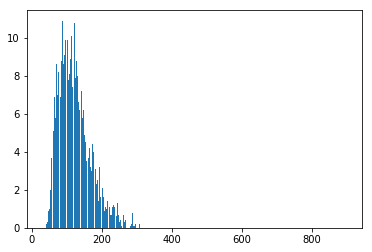

In [237]:
nee = CountNegEdgeExperiment(30, 10, 900)
nee.do_experiment()
nee.plot_results()

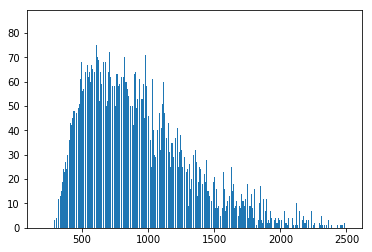

In [234]:
nee = CountNegEdgeExperiment(200, 1, 2500)
nee.do_experiment()
nee.plot_results()


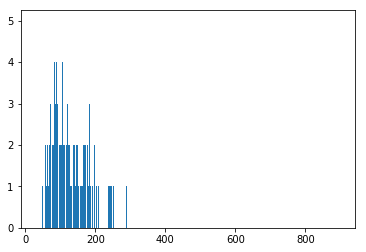

(None, 0)

In [240]:
dee = DeleteNegEdgeExperiment(30, 1, 900)
dee.do_experiment()
dee.plot_results(), len(dee.bad_graphs)

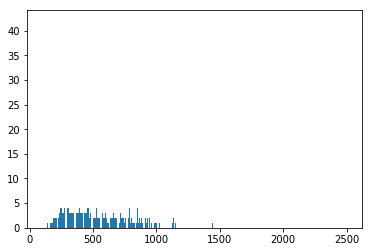

(None, 1)

In [210]:
dee = DeleteNegEdgeExperiment(100, 1, 2500)
dee.do_experiment()
dee.plot_results(), len(dee.bad_graphs)

In [214]:
bad_graph = dee.bad_graphs[0]


In [230]:
adj_mat = bad_graph.adj_mat
c = 0
for row in adj_mat:
    if np.sum(row) <= 1:
        c += 1
sum(adj_mat)

array([ 2.,  4.,  1.,  2.,  2.,  3.,  3.,  3.,  1.,  2.,  2.,  2.,  2.,
        2.,  1.,  2.,  2.,  2.,  1.,  3.,  2.,  2.,  2.,  2.,  2.,  1.,
        3.,  3.,  2.,  1.,  2.,  3.,  2.,  1.,  3.,  2.,  1.,  2.,  2.,
        1.,  1.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,  1.,  3.,  2.,  2.,
        2.,  2.,  1.,  1.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  1.,  1.,
        1.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,  3.,  1.,  1.,  1.,  2.,
        2.,  2.,  2.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  3.,  1.,  2.,  1.,  1.,  3.,  1.,  2.])

In [232]:
A = np.eye(2, 3)
A, sum(A)


(array([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.]]), array([ 1.,  1.,  0.]))